<a href="https://colab.research.google.com/github/rts1988/Duolingo_spaced_repetition/blob/main/Duolingo_q1studentcharacteristics_withsessionseen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Approach: 
1. group by delta, history fraction for every student, see if you can see who are the top performers, bottom performers. Is there a way to cluster them?

after trying in prev notebook, we now add session seen, and replace history correct with history fraction correct. 

In [1]:
import bz2
import pickle
import _pickle as cPickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

def decompress_pickle(file):
 data = bz2.BZ2File(file, 'rb')
 data = cPickle.load(data)
 return data

def compressed_pickle(title, data):  # do not add extension in filename
 with bz2.BZ2File(title + '.pbz2', 'w') as f: 
  cPickle.dump(data, f)

path_name = '/content/drive/MyDrive/'

Mounted at /content/drive


In [2]:
datadfq1 = decompress_pickle(path_name+"Unseen_words_training_set.pbz2") 

In [3]:
datadfq1.head()

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,student_word,student_lang
7,1.0,1362082032,444407,u:dDwF,es,en,73eecb492ca758ddab5371cf7b5cca32,bajo/bajo<pr>,3,3,1,1,"(u:dDwF, 73eecb492ca758ddab5371cf7b5cca32)","(u:dDwF, en)"
15,1.0,1362082130,77,u:dDwF,es,en,73eecb492ca758ddab5371cf7b5cca32,bajo/bajo<pr>,5,5,1,1,"(u:dDwF, 73eecb492ca758ddab5371cf7b5cca32)","(u:dDwF, en)"
20,1.0,1362082274,1634777,u:dDwF,es,en,c84476c460737d9fb905dca3d35ec995,niños/niño<n><m><pl>,9,8,2,2,"(u:dDwF, c84476c460737d9fb905dca3d35ec995)","(u:dDwF, en)"
21,1.0,1362082274,1708699,u:dDwF,es,en,1a913f2ded424985b9c02d0436008511,leo/leer<vblex><pri><p1><sg>,7,5,2,2,"(u:dDwF, 1a913f2ded424985b9c02d0436008511)","(u:dDwF, en)"
22,1.0,1362082274,1708699,u:dDwF,es,en,38b770e66595fea718366523b4f7db3f,libro/libro<n><m><sg>,8,8,4,4,"(u:dDwF, 38b770e66595fea718366523b4f7db3f)","(u:dDwF, en)"


For now, without looking at individual time traces of student-word, we will just look at student id, delta, history fraction, and see if we can predict if they forgot the word. (the difficulty of the word being captured in history fraction)

In [4]:
datadfq1['user_id'].value_counts().sort_values(ascending=False).head(3)

u:bcH_    12629
u:IY_      5528
u:hDLF     5147
Name: user_id, dtype: int64

We can use u:bcH_ as an example to train on. 

In [5]:
user1 = datadfq1.loc[datadfq1['user_id']=='u:bcH_']
user1['history_frac'] = user1['history_correct']/user1['history_seen']
user1 = user1[['delta','history_frac','p_recall','history_seen','session_seen']] # added session seen.
user1['p_forgot'] = 1 - user1['p_recall']
user1['p_forgot_bin'] = np.where(user1['p_forgot']>0,1,0).astype(int)
user1 = user1.drop(['p_forgot','p_recall'],axis=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [6]:
user1 = user1.sample(frac=1)

In [7]:
from sklearn.model_selection import train_test_split

X = user1.drop('p_forgot_bin',axis=1)
y = user1['p_forgot_bin']

X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X,y,test_size=.3,stratify=y)

In [8]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(1    0.622172
 0    0.377828
 Name: p_forgot_bin, dtype: float64, 1    0.622328
 0    0.377672
 Name: p_forgot_bin, dtype: float64)

In [9]:
from sklearn.preprocessing import MinMaxScaler
mm_scaler = MinMaxScaler()

X_train = mm_scaler.fit_transform(X_train_unscaled)
X_test = mm_scaler.fit(X_test_unscaled)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_validate

from sklearn.preprocessing import MinMaxScaler,StandardScaler

from sklearn.metrics import make_scorer # to define a list of scoring metrics to use

from sklearn.model_selection import GridSearchCV

classweight_vals = [{0:0.1, 1:0.9}, {0:0.01, 1:0.99}, {0:0.001,1:0.999}]
max_depth_vals = [2,4,6,8,10,12]

para_dict =dict()
para_dict['class_weight'] = classweight_vals
para_dict['max_depth'] = max_depth_vals


dtree = DecisionTreeClassifier()
scoring_metrics = ['accuracy','f1','average_precision','roc_auc','recall']

gridsearch_obj = GridSearchCV(dtree, param_grid = para_dict,cv=4,scoring = scoring_metrics, verbose=15,refit=False,return_train_score=True)

gridsearch_obj.fit(X_train_unscaled,y_train)


In [20]:
gridcv = pd.DataFrame(gridsearch_obj.cv_results_)
np.around(gridcv[['param_class_weight','param_max_depth','mean_fit_time',  'mean_score_time', 
       'mean_test_accuracy','mean_test_average_precision','mean_test_roc_auc','mean_test_f1','mean_test_recall']],2)

,param_class_weight,param_max_depth,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_average_precision,mean_test_roc_auc,mean_test_f1,mean_test_recall
0,"{0: 0.1, 1: 0.9}",2,0.02,0.02,0.62,0.71,0.63,0.77,1.00
1,"{0: 0.1, 1: 0.9}",4,0.02,0.02,0.62,0.74,0.65,0.77,1.00
2,"{0: 0.1, 1: 0.9}",6,0.03,0.03,0.62,0.74,0.65,0.76,0.99
3,"{0: 0.1, 1: 0.9}",8,0.04,0.03,0.62,0.75,0.65,0.76,0.98
4,"{0: 0.1, 1: 0.9}",10,0.07,0.04,0.62,0.74,0.65,0.76,0.97
5,"{0: 0.1, 1: 0.9}",12,0.04,0.02,0.61,0.73,0.63,0.75,0.94
6,"{0: 0.01, 1: 0.99}",2,0.01,0.02,0.62,0.70,0.61,0.77,1.00
7,"{0: 0.01, 1: 0.99}",4,0.02,0.02,0.62,0.72,0.63,0.77,1.00
8,"{0: 0.01, 1: 0.99}",6,0.03,0.02,0.62,0.74,0.65,0.76,0.99
9,"{0: 0.01, 1: 0.99}",8,0.03,0.02,0.62,0.75,0.65,0.76,0.99


class_weight = {0: 0.3, 1: 0.7}, max_depth=4 has the best results, although test accuracy was the same as always 1 baseline throughout. 

In [24]:
gridcv['weight1'] = gridcv['param_class_weight'].apply(lambda x: x[1])

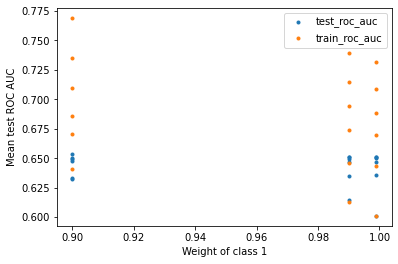

In [25]:
plt.figure()
plt.xlabel("Weight of class 1")
plt.ylabel("Mean test ROC AUC")
plt.plot(gridcv['weight1'],gridcv['mean_test_roc_auc'],'.' ,label = 'test_roc_auc')
plt.plot(gridcv['weight1'],gridcv['mean_train_roc_auc'],'.', label = 'train_roc_auc')
plt.legend()
plt.show()

This justifies considering even higher weights for 1, since the mean test ROC AUC keeps increasing. we will keep depth to 4. 

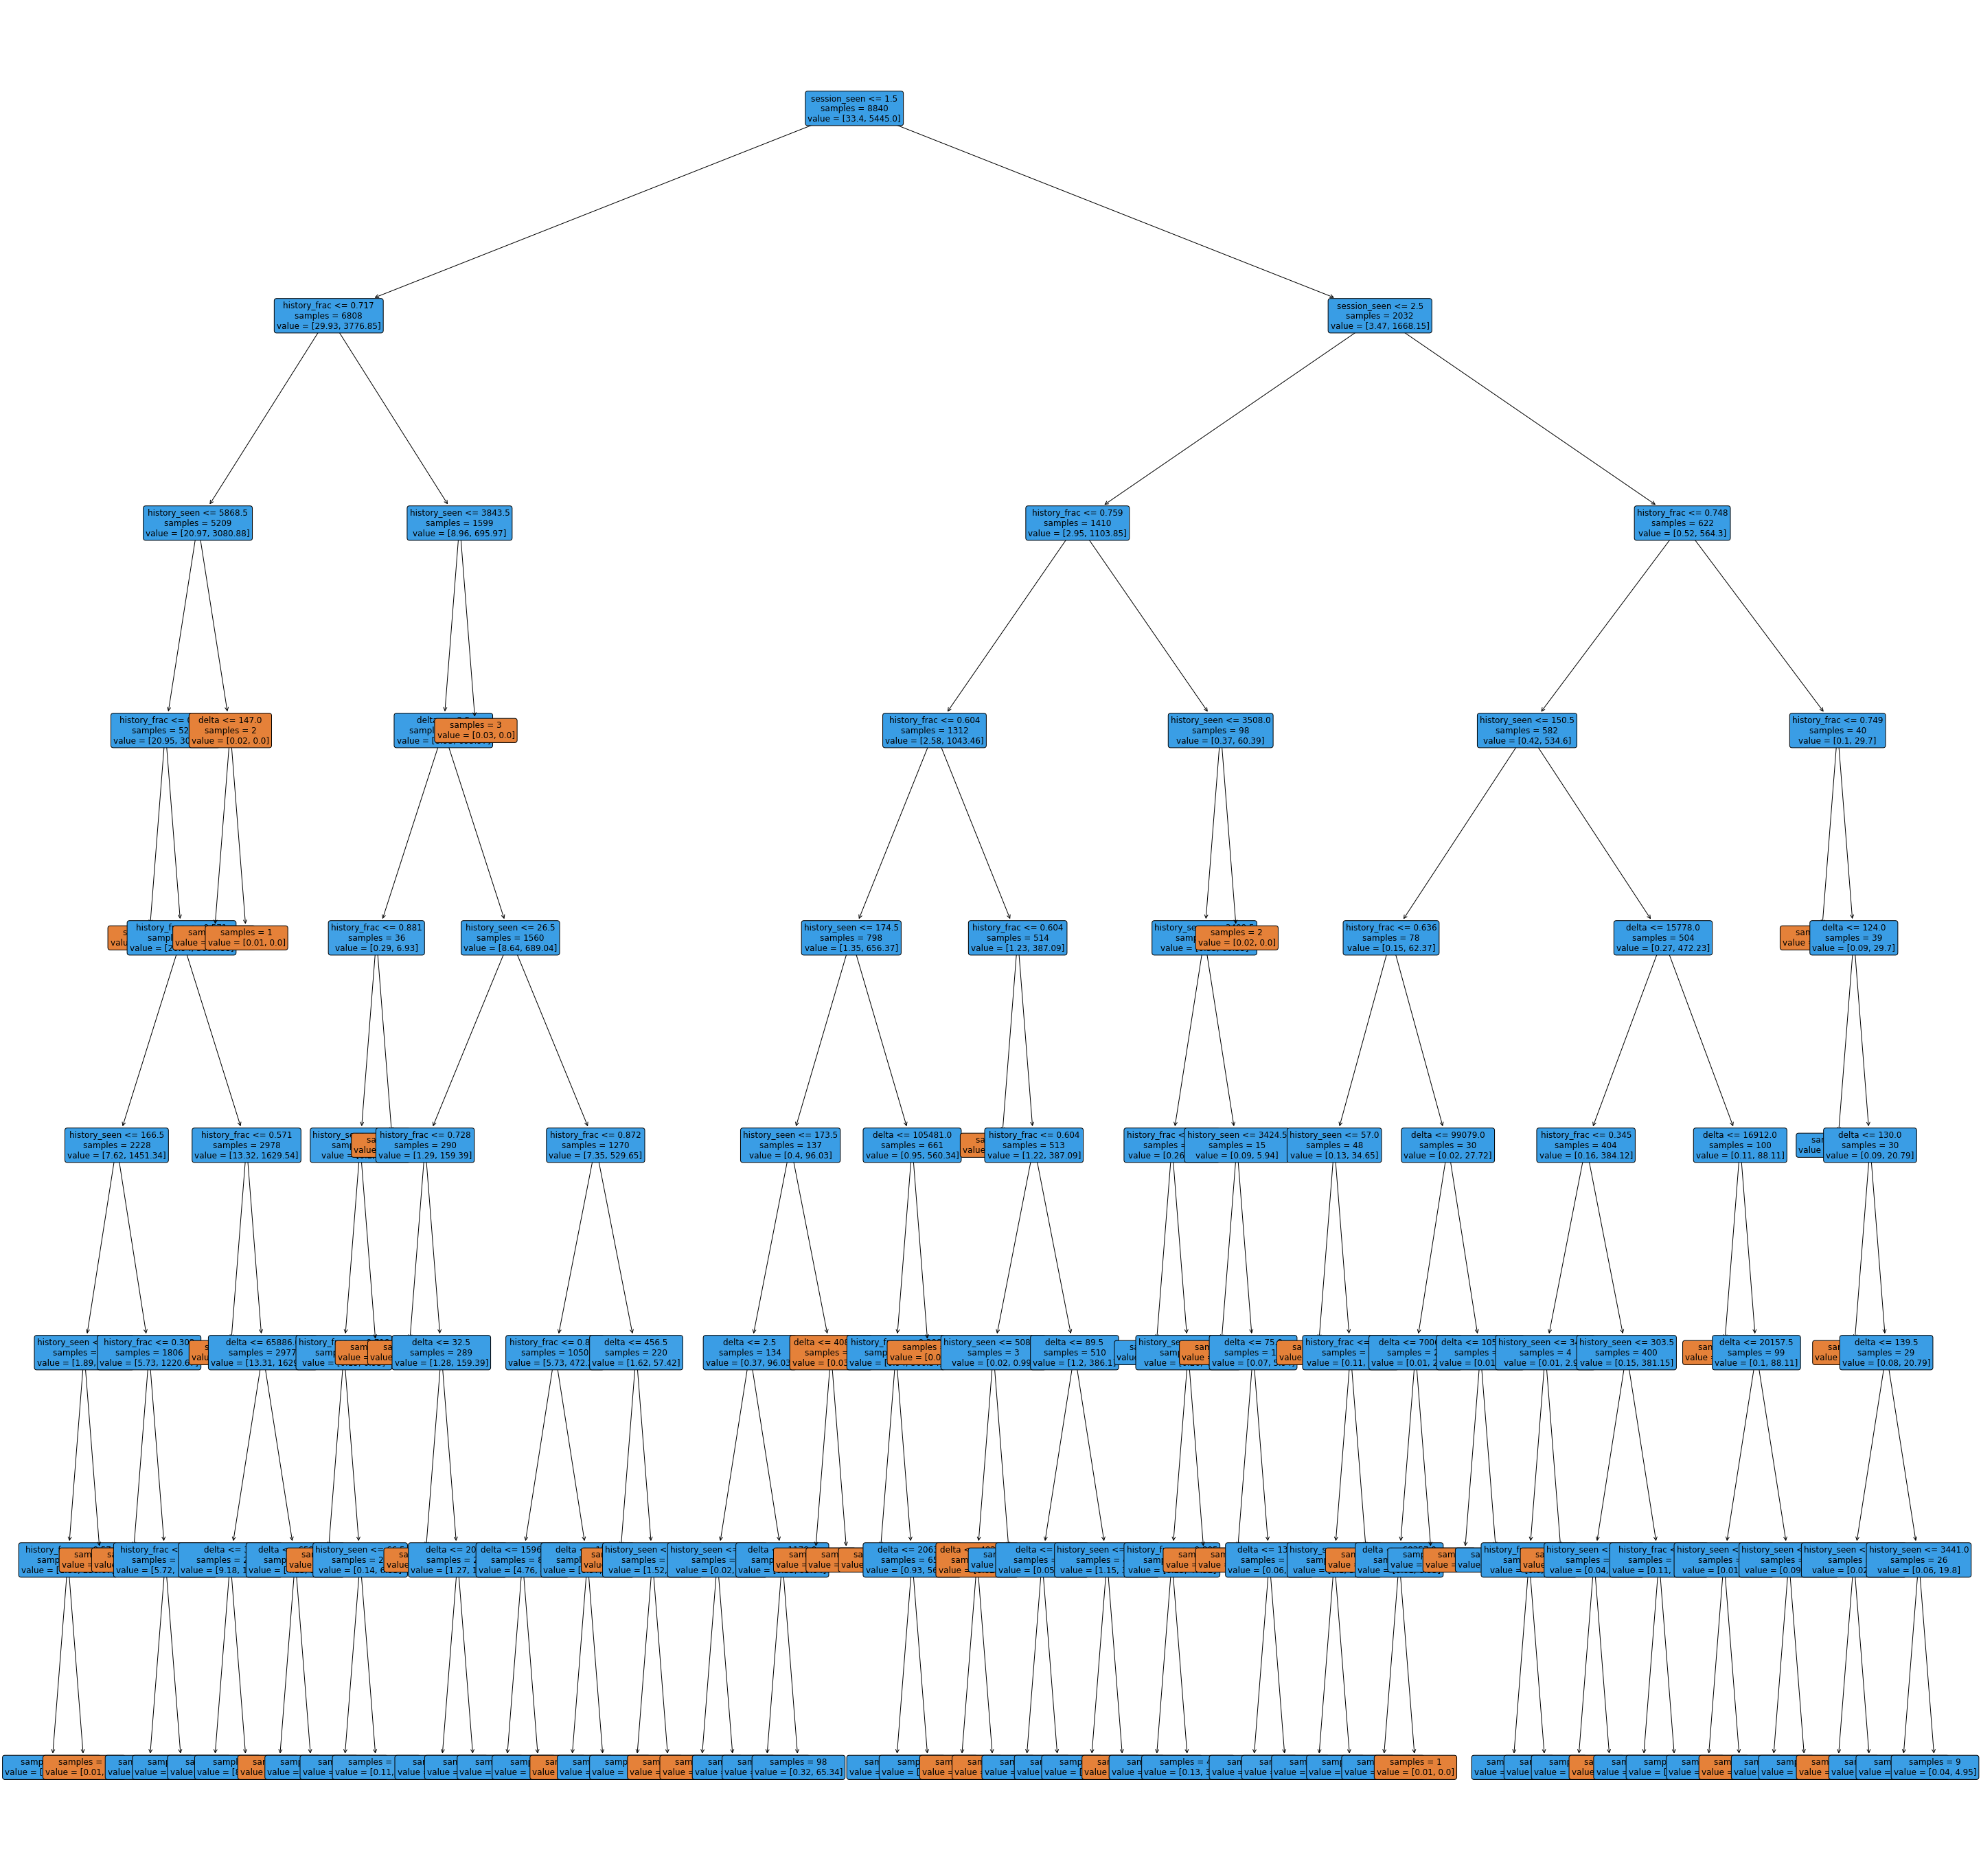

In [28]:
dtreebest = DecisionTreeClassifier(max_depth=8,class_weight = {0:.01,1:0.99})
dtreebest.fit(X_train_unscaled,y_train)

from sklearn.tree import plot_tree
plt.figure(figsize=(50,50))
plot_tree(dtree, 
          feature_names=X.columns, 
          rounded=True,
          impurity=False,
          filled=True,
          fontsize=12)
plt.show()

In [29]:
pd.Series(dict(zip(X_train_unscaled.columns,dtreebest.feature_importances_))).sort_values(ascending=False)

history_seen    0.431067
delta           0.268045
history_frac    0.255782
session_seen    0.045106
dtype: float64

Trying random forests:

In [32]:
from sklearn.ensemble import RandomForestClassifier

my_random_forest = RandomForestClassifier(n_estimators=3,max_features=1)
my_random_forest.fit(X_train_unscaled, y_train)
 

RandomForestClassifier(max_features=1, n_estimators=3)

In [33]:
from sklearn.metrics import accuracy_score

y_train_predicted = my_random_forest.predict(X_train_unscaled)
y_test_predicted = my_random_forest.predict(X_test_unscaled)
accuracy_score(y_train,y_train_predicted), accuracy_score(y_test,y_test_predicted)

(0.9190045248868778, 0.5814198997096859)

Way overfit with a very small number of estimators inspite of adding max_features limit. (only 3 features anyway)

Just for fun, we can try XGBoost

In [35]:
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler

mm_scaler = MinMaxScaler()
mm_scaler.fit(X_train_unscaled)
X_mm_train = mm_scaler.transform(X_train_unscaled)
X_mm_test = mm_scaler.transform(X_test_unscaled)
XGB_model = XGBClassifier()
XGB_model.fit(X_mm_train, y_train)
print(f"XG Boost test set score: {XGB_model.score(X_mm_test, y_test)}")
print(f"XG Boost train set score: {XGB_model.score(X_mm_train, y_train)}")

XG Boost test set score: 0.6421219319081551
XG Boost train set score: 0.6704751131221719


In [36]:
from sklearn.ensemble import AdaBoostClassifier
AB_model = AdaBoostClassifier()
AB_model.fit(X_mm_train, y_train)
print(f"Ada Boost test set score: {AB_model.score(X_mm_test, y_test)}")
print(f"Ada Boost train set score: {AB_model.score(X_mm_train, y_train)}")

Ada Boost test set score: 0.6355238849300607
Ada Boost train set score: 0.6596153846153846


With session seen and history fraction added in, performance is slightly improved, but not by much. Test accuracy is still at baseline all 1 level.